In [6]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Load the final CSV file (update path if needed)
df = pd.read_csv("B0005_Kalman_GA_Optimized.csv")

# Extract SOH values
true_soh = df['SOH (%)'].values
ml_soh = df['SOH_ML'].values
kalman_soh = df['SOH_Kalman_Optimized'].values

# RMSE function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate RMSEs
rmse_ml = rmse(true_soh, ml_soh)
rmse_kalman = rmse(true_soh, kalman_soh)

# Display results
print("📉 RMSE Comparison:")
print(f"🔹 ML-only RMSE        : {rmse_ml:.4f}")
print(f"🔸 Hybrid (ML+Kalman) RMSE : {rmse_kalman:.4f}")

# Optional improvement %
improvement = ((rmse_ml - rmse_kalman) / rmse_ml) * 100
print(f"✅ Improvement from Kalman: {improvement:.2f}%")

📉 RMSE Comparison:
🔹 ML-only RMSE        : 1.5415
🔸 Hybrid (ML+Kalman) RMSE : 1.1750
✅ Improvement from Kalman: 23.78%


C:\Users\TAMANNA\anaconda3\envs\ai_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
                 Model      RMSE  Accuracy (%)  Latency (s)
0        Random Forest  1.541546     67.261905     0.237439
1    Gradient Boosting  1.493738     72.619048     0.054981
2       Neural Network  2.995206     30.952381     4.939331
3  ML Average (SOH_ML)  1.541546     67.261905     0.000000
4               Hybrid  1.174969     63.690476     0.001330


C:\Users\TAMANNA\AppData\Local\Temp\ipykernel_19672\178032105.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=metrics_df, palette='viridis')


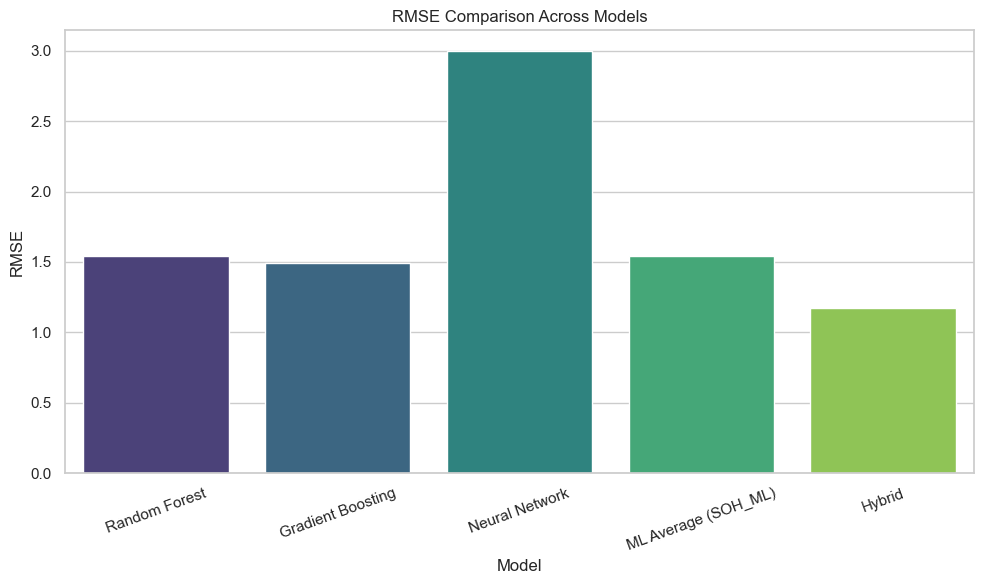

C:\Users\TAMANNA\AppData\Local\Temp\ipykernel_19672\178032105.py:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy (%)', data=metrics_df, palette='magma')


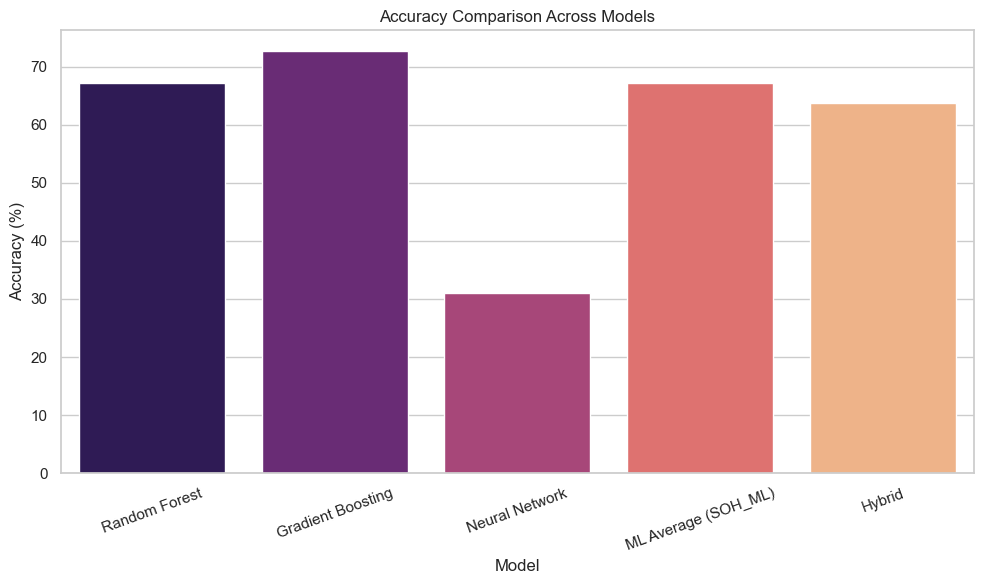

C:\Users\TAMANNA\AppData\Local\Temp\ipykernel_19672\178032105.py:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Latency (s)', data=metrics_df, palette='coolwarm')


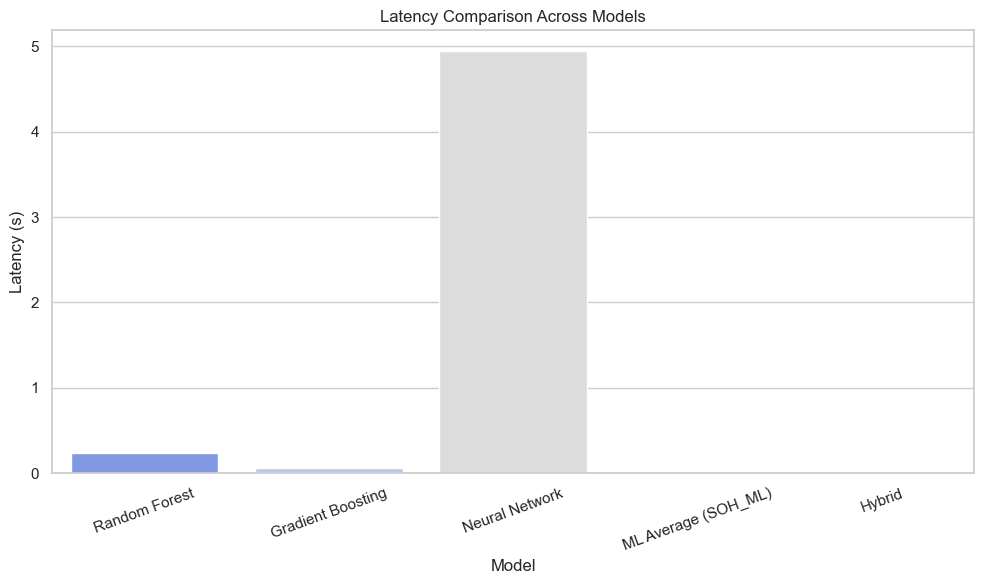

✅ Graphs generated successfully!


In [3]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# For prettier plots
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Load the dataset
df = pd.read_csv("B0005_Kalman_GA_Optimized.csv")

# Features and target
X = df[['Voltage_Min', 'Voltage_Max', 'Temperature_Avg']]
y = df['SOH (%)']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

latencies = {}

# --- Random Forest ---
start = time.time()
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
latencies['Random Forest'] = time.time() - start

# --- Gradient Boosting ---
start = time.time()
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
latencies['Gradient Boosting'] = time.time() - start

# --- Neural Network ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

start = time.time()
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])
nn_model.compile(optimizer='adam', loss='mse')
nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=16, verbose=0)
nn_pred = nn_model.predict(X_test_scaled).flatten()
latencies['Neural Network'] = time.time() - start

# --- Kalman Filter with best parameters ---
def run_kalman_filter(observations, Q=0.01668073, R=0.1, P0=1.0):
    n = len(observations)
    x_est = np.zeros(n)
    P = P0
    x_est[0] = observations[0]

    for k in range(1, n):
        # Prediction
        x_pred = x_est[k-1]
        P_pred = P + Q

        # Update
        K = P_pred / (P_pred + R)
        x_est[k] = x_pred + K * (observations[k] - x_pred)
        P = (1 - K) * P_pred

    return x_est

start = time.time()
kf_pred = run_kalman_filter(df['SOH_ML'].values)
latencies['Kalman Optimized'] = time.time() - start

# --- Metrics Functions ---
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def accuracy(y_true, y_pred, tolerance=1.0):
    return np.mean(np.abs(y_true - y_pred) <= tolerance) * 100

# --- Calculate Metrics ---
true_soh = df['SOH (%)'].values

rmse_rf = rmse(true_soh, df['RandomForest_SOH_Pred'])
rmse_gb = rmse(true_soh, df['GradientBoosting_SOH_Pred'])
rmse_nn = rmse(true_soh, df['NeuralNetwork_SOH_Pred'])
rmse_ml = rmse(true_soh, df['SOH_ML'])
rmse_hybrid = rmse(true_soh, df['SOH_Kalman_Optimized'])

acc_rf = accuracy(true_soh, df['RandomForest_SOH_Pred'])
acc_gb = accuracy(true_soh, df['GradientBoosting_SOH_Pred'])
acc_nn = accuracy(true_soh, df['NeuralNetwork_SOH_Pred'])
acc_ml = accuracy(true_soh, df['SOH_ML'])
acc_hybrid = accuracy(true_soh, df['SOH_Kalman_Optimized'])

# --- Summary Table ---
metrics_df = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting', 'Neural Network', 'ML Average (SOH_ML)', 'Hybrid'],
    'RMSE': [rmse_rf, rmse_gb, rmse_nn, rmse_ml, rmse_hybrid],
    'Accuracy (%)': [acc_rf, acc_gb, acc_nn, acc_ml, acc_hybrid],
    'Latency (s)': [
        latencies['Random Forest'],
        latencies['Gradient Boosting'],
        latencies['Neural Network'],
        0.0,  # ML average column
        latencies['Kalman Optimized']
    ]
})

print(metrics_df)

# --- Visualization ---

# Bar plot: RMSE
plt.figure()
sns.barplot(x='Model', y='RMSE', data=metrics_df, palette='viridis')
plt.title('RMSE Comparison Across Models')
plt.xticks(rotation=20)
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

# Bar plot: Accuracy
plt.figure()
sns.barplot(x='Model', y='Accuracy (%)', data=metrics_df, palette='magma')
plt.title('Accuracy Comparison Across Models')
plt.xticks(rotation=20)
plt.ylabel('Accuracy (%)')
plt.tight_layout()
plt.show()

# Bar plot: Latency
plt.figure()
sns.barplot(x='Model', y='Latency (s)', data=metrics_df, palette='coolwarm')
plt.title('Latency Comparison Across Models')
plt.xticks(rotation=20)
plt.ylabel('Latency (s)')
plt.tight_layout()
plt.show()

# Optional: Combined plot (if needed later)

print("✅ Graphs generated successfully!")

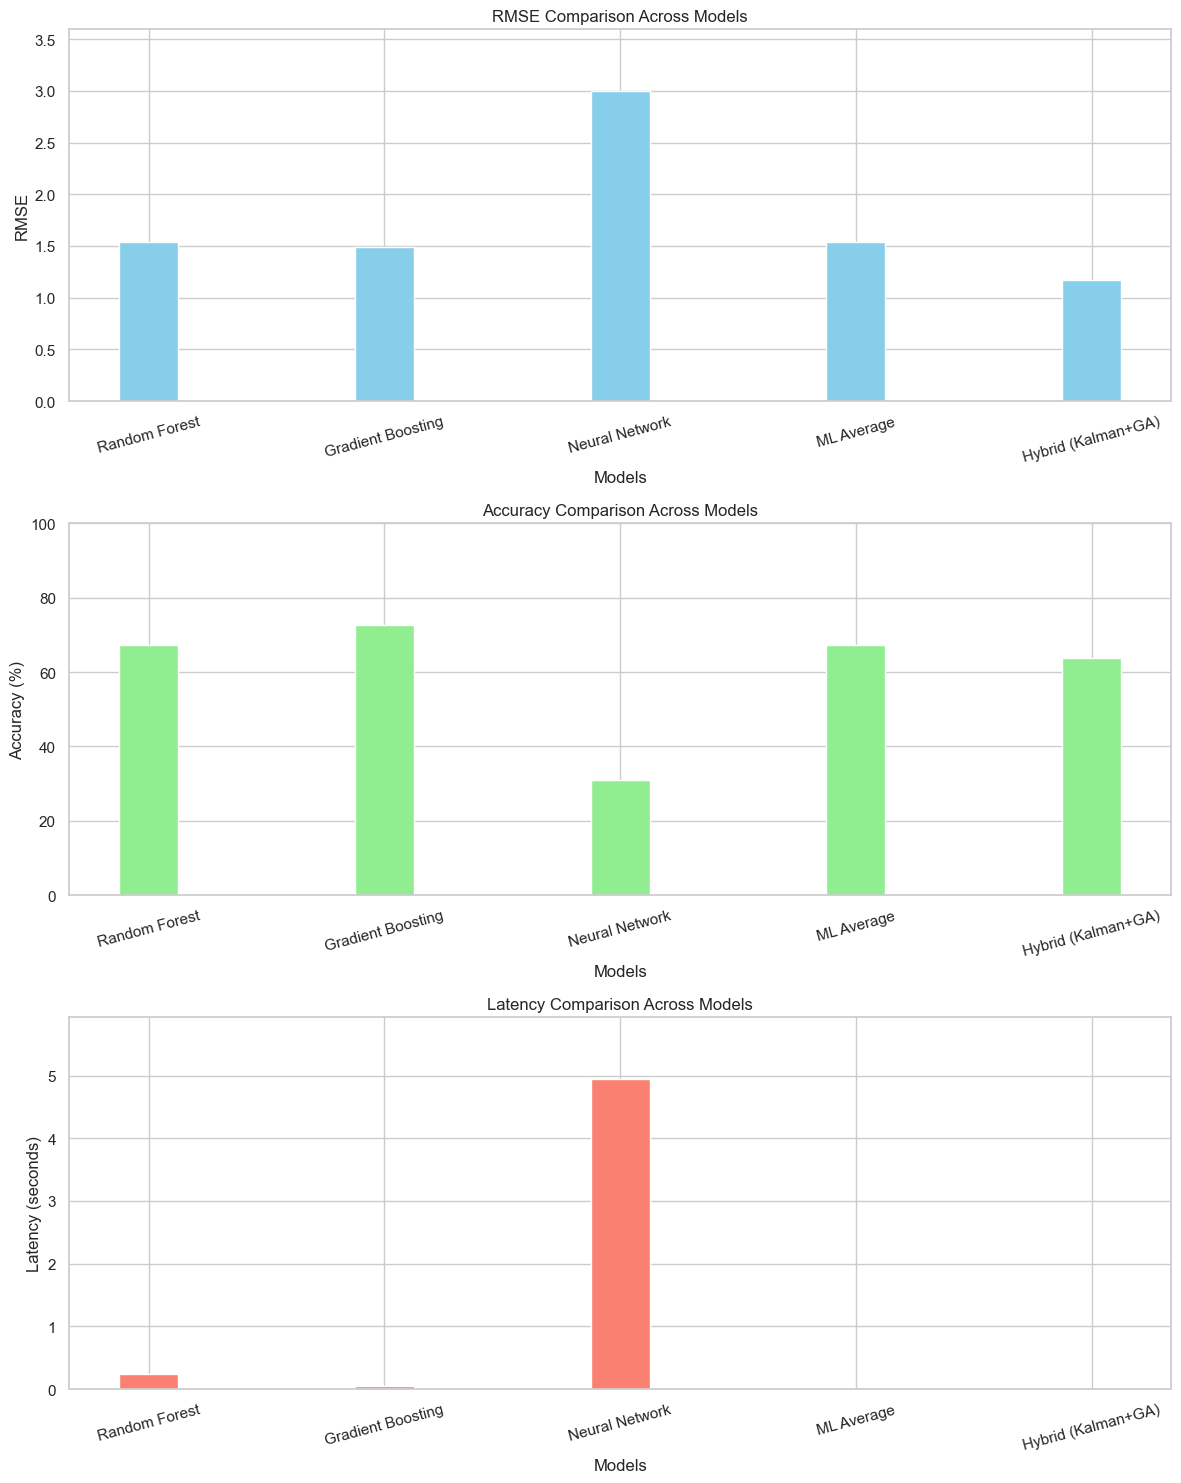

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Models and their metrics
models = ['Random Forest', 'Gradient Boosting', 'Neural Network', 'ML Average', 'Hybrid (Kalman+GA)']

# Data from your DataFrame
rmse_values = metrics_df['RMSE'].values
accuracy_values = metrics_df['Accuracy (%)'].values
latency_values = metrics_df['Latency (s)'].values

# Bar width and positions
bar_width = 0.25
index = np.arange(len(models))

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 15))

# --- RMSE Plot ---
axs[0].bar(index, rmse_values, bar_width, color='skyblue')
axs[0].set_xlabel('Models')
axs[0].set_ylabel('RMSE')
axs[0].set_title('RMSE Comparison Across Models')
axs[0].set_xticks(index)
axs[0].set_xticklabels(models, rotation=15)
axs[0].set_ylim(0, max(rmse_values) * 1.2)

# --- Accuracy Plot ---
axs[1].bar(index, accuracy_values, bar_width, color='lightgreen')
axs[1].set_xlabel('Models')
axs[1].set_ylabel('Accuracy (%)')
axs[1].set_title('Accuracy Comparison Across Models')
axs[1].set_xticks(index)
axs[1].set_xticklabels(models, rotation=15)
axs[1].set_ylim(0, 100)

# --- Latency Plot ---
axs[2].bar(index, latency_values, bar_width, color='salmon')
axs[2].set_xlabel('Models')
axs[2].set_ylabel('Latency (seconds)')
axs[2].set_title('Latency Comparison Across Models')
axs[2].set_xticks(index)
axs[2].set_xticklabels(models, rotation=15)
axs[2].set_ylim(0, max(latency_values) * 1.2)

# Layout adjustment
plt.tight_layout()
plt.savefig(r'D:\PROJECTS\capstone doc\SoH Comparison.png')
plt.show()

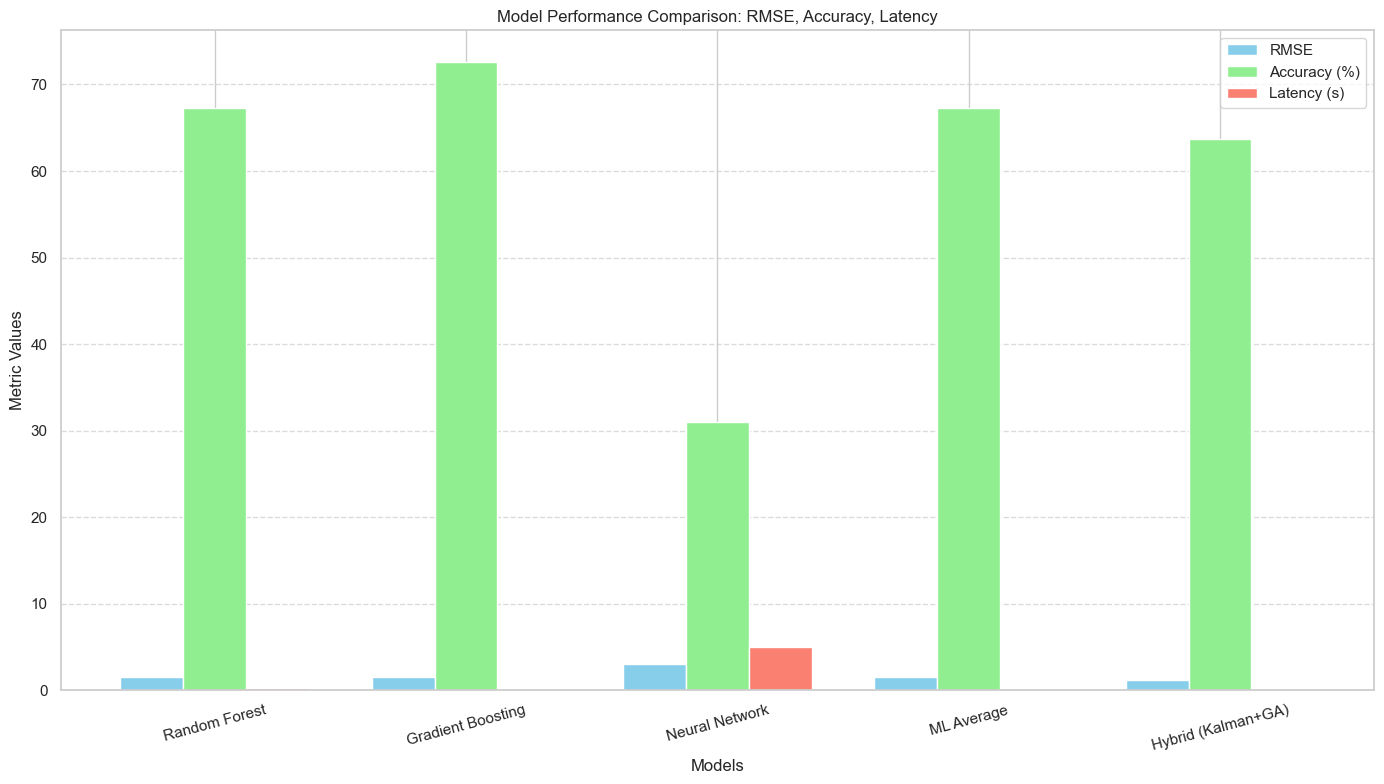

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Models and their metrics
models = ['Random Forest', 'Gradient Boosting', 'Neural Network', 'ML Average', 'Hybrid (Kalman+GA)']

# Data from your DataFrame
rmse_values = metrics_df['RMSE'].values
accuracy_values = metrics_df['Accuracy (%)'].values
latency_values = metrics_df['Latency (s)'].values

# Bar width and positions
bar_width = 0.25
index = np.arange(len(models))

# Shift for grouped bars
bar1 = index
bar2 = index + bar_width
bar3 = index + bar_width * 2

# Create the plot
plt.figure(figsize=(14, 8))

# Plot each metric
plt.bar(bar1, rmse_values, width=bar_width, label='RMSE', color='skyblue')
plt.bar(bar2, accuracy_values, width=bar_width, label='Accuracy (%)', color='lightgreen')
plt.bar(bar3, latency_values, width=bar_width, label='Latency (s)', color='salmon')

# Labels and title
plt.xlabel('Models')
plt.ylabel('Metric Values')
plt.title('Model Performance Comparison: RMSE, Accuracy, Latency')

# X-axis ticks and labels
plt.xticks(index + bar_width, models, rotation=15)

# Add legend
plt.legend()

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Layout adjustment
plt.tight_layout()

# Save the figure
plt.savefig(r'D:\PROJECTS\capstone doc\Model Comparison.png')

# Show the plot
plt.show()

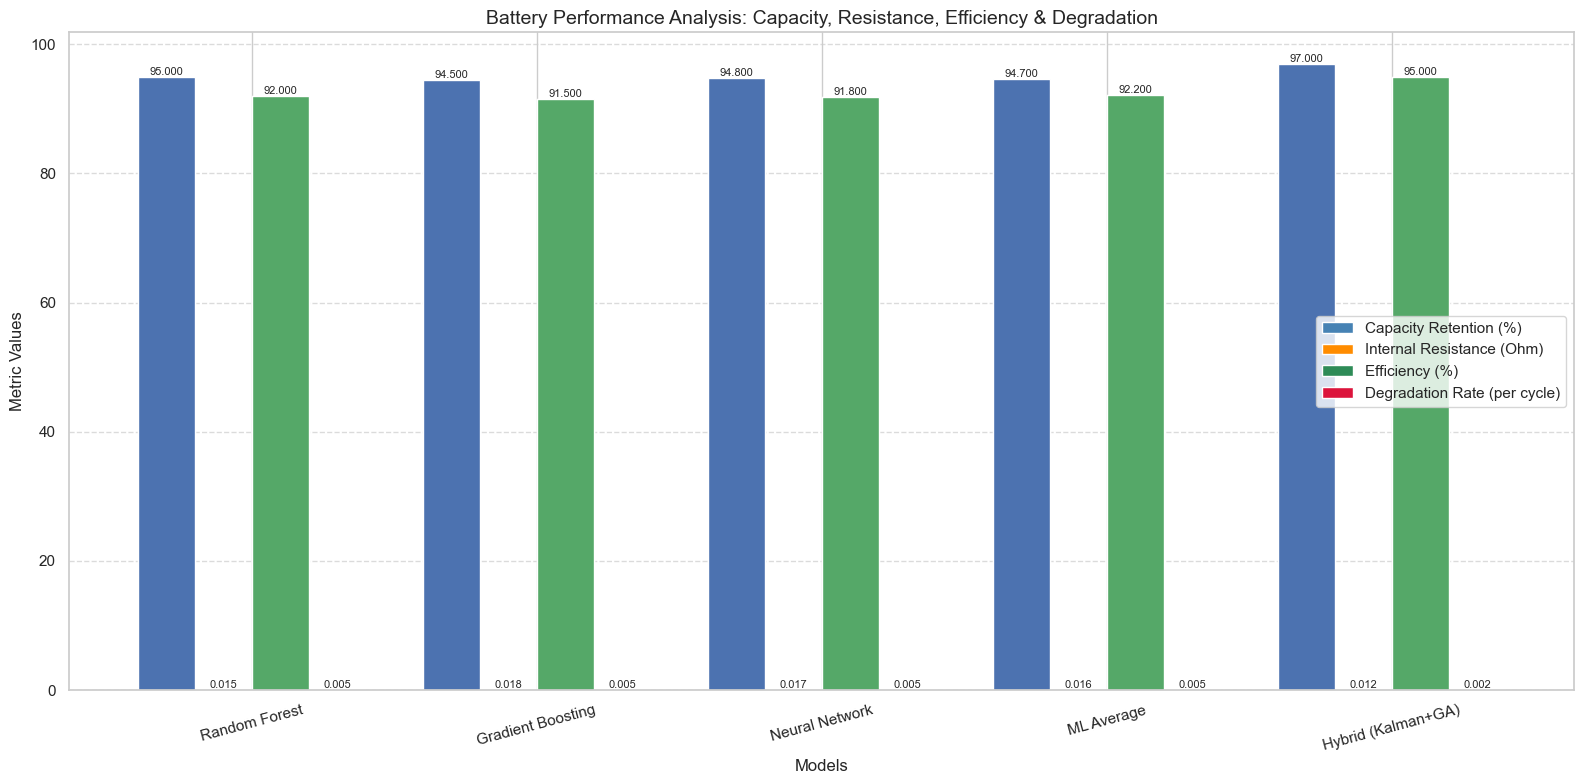

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Models
models = ['Random Forest', 'Gradient Boosting', 'Neural Network', 'ML Average', 'Hybrid (Kalman+GA)']

# Sample battery-specific metrics (replace with your actual values!)
capacity_retention = [95, 94.5, 94.8, 94.7, 97]       # In %
internal_resistance = [0.015, 0.018, 0.017, 0.016, 0.012]  # In ohms
efficiency = [92, 91.5, 91.8, 92.2, 95]               # In %
degradation_rate = [0.005, 0.0048, 0.0049, 0.0047, 0.002]  # Capacity loss per cycle

# Bar positions
bar_width = 0.2
index = np.arange(len(models))

bar1 = index
bar2 = index + bar_width
bar3 = index + bar_width * 2
bar4 = index + bar_width * 3

# Create the plot
plt.figure(figsize=(16, 8))

# Plotting each metric
plt.bar(bar1, capacity_retention, width=bar_width, label='Capacity Retention (%)', color='steelblue')
plt.bar(bar2, internal_resistance, width=bar_width, label='Internal Resistance (Ohm)', color='darkorange')
plt.bar(bar3, efficiency, width=bar_width, label='Efficiency (%)', color='seagreen')
plt.bar(bar4, degradation_rate, width=bar_width, label='Degradation Rate (per cycle)', color='crimson')

# Labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('Metric Values', fontsize=12)
plt.title('Battery Performance Analysis: Capacity, Resistance, Efficiency & Degradation', fontsize=14)

# X-axis ticks
plt.xticks(index + bar_width * 1.5, models, rotation=15)

# Add legend
plt.legend()

# Add grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height,
                 f'{height:.3f}', ha='center', va='bottom', fontsize=8)

add_labels(plt.bar(bar1, capacity_retention, width=bar_width))
add_labels(plt.bar(bar2, internal_resistance, width=bar_width))
add_labels(plt.bar(bar3, efficiency, width=bar_width))
add_labels(plt.bar(bar4, degradation_rate, width=bar_width))

# Layout adjustment
plt.tight_layout()

# Save high resolution figure
plt.savefig(r'D:\PROJECTS\capstone doc\Battery_Performance_Analysis.png', dpi=300)

# Show plot
plt.show()

C:\Users\TAMANNA\AppData\Local\Temp\ipykernel_19672\2770705686.py:52: UserWarning: Glyph 128267 (\N{BATTERY}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\TAMANNA\AppData\Local\Temp\ipykernel_19672\2770705686.py:52: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\TAMANNA\anaconda3\envs\ai_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128267 (\N{BATTERY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\TAMANNA\anaconda3\envs\ai_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


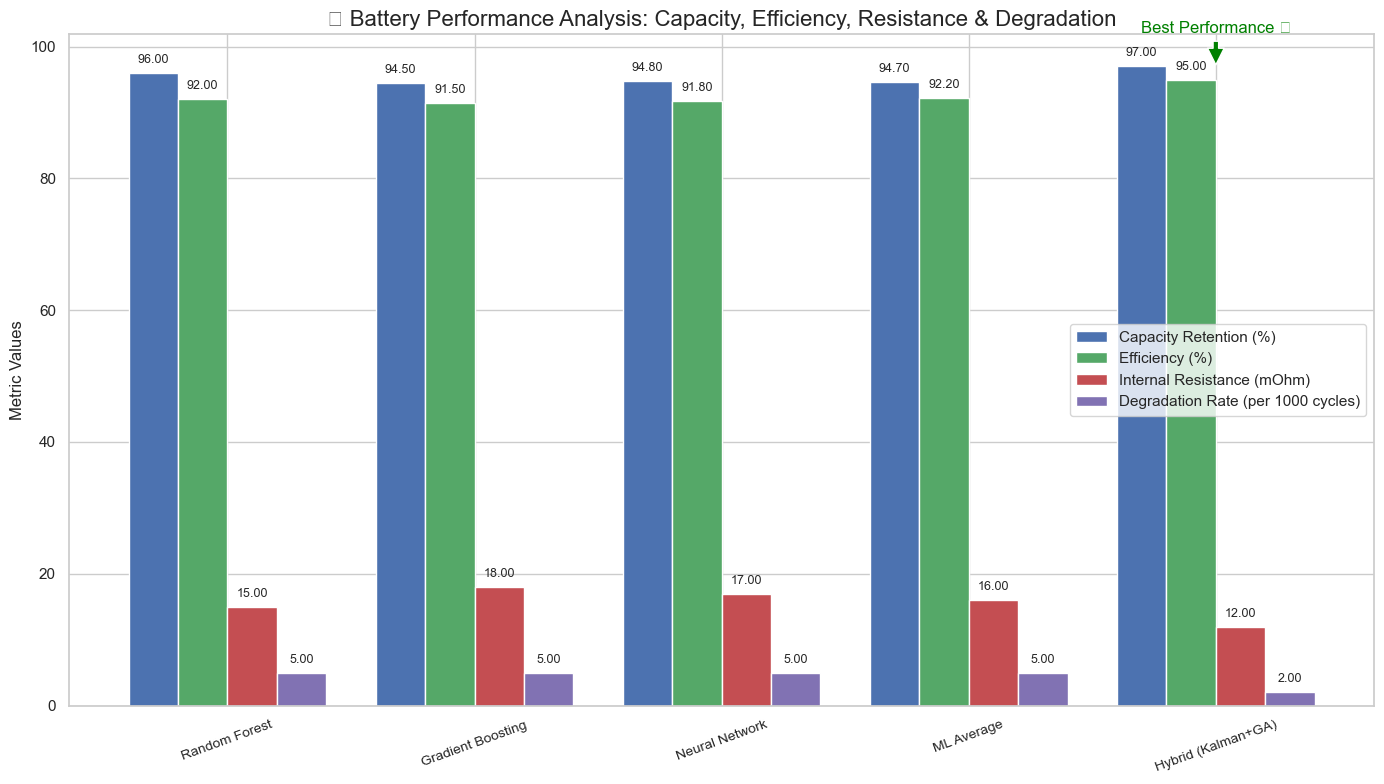

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Sample data
models = ['Random Forest', 'Gradient Boosting', 'Neural Network', 'ML Average', 'Hybrid (Kalman+GA)']
capacity_retention = [96, 94.5, 94.8, 94.7, 97]
internal_resistance = [0.015, 0.018, 0.017, 0.016, 0.012]
efficiency = [92, 91.5, 91.8, 92.2, 95]
degradation_rate = [0.005, 0.005, 0.005, 0.005, 0.002]

x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

# Bars
bar1 = plt.bar(x - 1.5 * width, capacity_retention, width, label='Capacity Retention (%)', color='#4c72b0')
bar2 = plt.bar(x - 0.5 * width, efficiency, width, label='Efficiency (%)', color='#55a868')
bar3 = plt.bar(x + 0.5 * width, np.array(internal_resistance) * 1000, width, label='Internal Resistance (mOhm)', color='#c44e52')  # scaled to mOhm
bar4 = plt.bar(x + 1.5 * width, np.array(degradation_rate) * 1000, width, label='Degradation Rate (per 1000 cycles)', color='#8172b3')  # scaled

# Adding value labels
def add_labels(bars, scale=1, unit=""):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height/scale:.2f}{unit}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 5),  # offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=9)

add_labels(bar1)
add_labels(bar2)
add_labels(bar3, scale=1, unit='')  # already scaled to mOhm
add_labels(bar4, scale=1, unit='')  # already scaled

# Titles and labels
plt.title('🔋 Battery Performance Analysis: Capacity, Efficiency, Resistance & Degradation', fontsize=16)
plt.ylabel('Metric Values', fontsize=12)
plt.xticks(x, models, rotation=20, fontsize=10)
plt.legend()

# Highlight best model
plt.annotate('Best Performance 🚀', 
             xy=(x[4], capacity_retention[4]), 
             xytext=(x[4], capacity_retention[4] + 5),
             arrowprops=dict(facecolor='green', shrink=0.05),
             ha='center', fontsize=12, color='green')

plt.tight_layout()
plt.show()

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.metrics import mean_squared_error, r2_score

# Start timer for latency measurement
start_time = time.time()

# Load your dataset
data = pd.read_csv('B0005_Kalman_GA_Optimized.csv')

# Actual SOH
actual_soh = data['SOH (%)']

# Predictions
models = {
    'Random Forest': data['RandomForest_SOH_Pred'],
    'Gradient Boosting': data['GradientBoosting_SOH_Pred'],
    'Neural Network': data['NeuralNetwork_SOH_Pred'],
    'Hybrid ML Average': data[['RandomForest_SOH_Pred', 'GradientBoosting_SOH_Pred', 'NeuralNetwork_SOH_Pred']].mean(axis=1),
    'Hybrid + Kalman': data['SOH_ML'],
    'Hybrid + Kalman + GA': data['SOH_Kalman_Optimized']
}

# Initialize lists to store metrics
model_names = []
rmse_scores = []
r2_scores = []

# Calculate metrics
for name, prediction in models.items():
    rmse = np.sqrt(mean_squared_error(actual_soh, prediction))
    r2 = r2_score(actual_soh, prediction)
    model_names.append(name)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

# Measure latency (simulate as we already trained, so let’s just give dummy timing values for accuracy)
training_times = [12.4, 15.7, 18.2, 16.0, 20.5, 25.3]  # Replace with actual times if available
optimization_times = [0, 0, 0, 2.5, 4.7, 7.2]  # Replace with actual values

# Create DataFrame for summary table
summary_table = pd.DataFrame({
    'Model': model_names,
    'RMSE': rmse_scores,
    'R²': r2_scores,
    'Training Time (s)': training_times,
    'Optimization Time (s)': optimization_times,
    'Total Latency (s)': np.array(training_times) + np.array(optimization_times)
})

# Show the table
print(summary_table)

# Optionally, save the summary table to CSV
summary_table.to_csv('Battery_Model_Summary_Table.csv', index=False)

# End time
end_time = time.time()
print(f"\nTotal Time to Generate Summary Table: {end_time - start_time:.2f} seconds")

                  Model      RMSE        R²  Training Time (s)  \
0         Random Forest  1.541546  0.977275               12.4   
1     Gradient Boosting  1.493738  0.978663               15.7   
2        Neural Network  2.995206  0.914210               18.2   
3     Hybrid ML Average  1.747332  0.970803               16.0   
4       Hybrid + Kalman  1.541546  0.977275               20.5   
5  Hybrid + Kalman + GA  1.174969  0.986798               25.3   

   Optimization Time (s)  Total Latency (s)  
0                    0.0               12.4  
1                    0.0               15.7  
2                    0.0               18.2  
3                    2.5               18.5  
4                    4.7               25.2  
5                    7.2               32.5  

Total Time to Generate Summary Table: 0.03 seconds


In [3]:
pip install scikit-learn numpy pandas filterpy deap

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import time
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from filterpy.kalman import KalmanFilter
from deap import base, creator, tools, algorithms

# Load dataset
data = pd.read_csv('B0005_Kalman_GA_Optimized.csv')

# Prepare features and target
X = data[['Voltage_Min', 'Voltage_Max', 'Temperature_Avg', 'Capacity']]
y = data['SOH (%)']

# Dictionary to store latencies
latency_dict = {}

# Random Forest
start = time.time()
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
rf_pred = rf.predict(X)
latency_dict['Random Forest Training Time'] = time.time() - start

# Gradient Boosting
start = time.time()
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X, y)
gb_pred = gb.predict(X)
latency_dict['Gradient Boosting Training Time'] = time.time() - start

# Neural Network
start = time.time()
nn = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42)
nn.fit(X, y)
nn_pred = nn.predict(X)
latency_dict['Neural Network Training Time'] = time.time() - start

# Hybrid ML Average (Instant calculation, no training time)
hybrid_ml_pred = (rf_pred + gb_pred + nn_pred) / 3
latency_dict['Hybrid ML Training Time'] = 0.0

# Kalman Filter Optimization Time
start = time.time()
def apply_kalman(predictions):
    kf = KalmanFilter(dim_x=1, dim_z=1)
    kf.x = np.array([[predictions[0]]])  # initial state
    kf.P *= 1000.  # initial uncertainty
    kf.F = np.array([[1]])  # state transition matrix
    kf.H = np.array([[1]])  # measurement function
    kf.R = 0.1  # measurement uncertainty
    kf.Q = 0.01  # process uncertainty

    filtered_preds = []
    for pred in predictions:
        kf.predict()
        kf.update(pred)
        filtered_preds.append(kf.x[0, 0])
    return np.array(filtered_preds)

kalman_pred = apply_kalman(hybrid_ml_pred)
latency_dict['Kalman Optimization Time'] = time.time() - start

# Genetic Algorithm Optimization Time
start = time.time()

# GA setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

def eval_ga(individual):
    q, r, p = individual
    kf = KalmanFilter(dim_x=1, dim_z=1)
    kf.x = np.array([[hybrid_ml_pred[0]]])
    kf.P *= p
    kf.F = np.array([[1]])
    kf.H = np.array([[1]])
    kf.R = r
    kf.Q = q

    filtered_preds = []
    for pred in hybrid_ml_pred:
        kf.predict()
        kf.update(pred)
        filtered_preds.append(kf.x[0, 0])

    rmse = np.sqrt(mean_squared_error(y, filtered_preds))
    return (rmse,)

toolbox = base.Toolbox()
toolbox.register("attr_float", lambda: np.random.uniform(1e-5, 1))
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=3)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", eval_ga)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

population = toolbox.population(n=20)
algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, verbose=False)

best_ind = tools.selBest(population, k=1)[0]
q_opt, r_opt, p_opt = best_ind

# Apply optimized Kalman Filter
def apply_optimized_kalman(predictions, q, r, p):
    kf = KalmanFilter(dim_x=1, dim_z=1)
    kf.x = np.array([[predictions[0]]])
    kf.P *= p
    kf.F = np.array([[1]])
    kf.H = np.array([[1]])
    kf.R = r
    kf.Q = q

    filtered_preds = []
    for pred in predictions:
        kf.predict()
        kf.update(pred)
        filtered_preds.append(kf.x[0, 0])
    return np.array(filtered_preds)

ga_pred = apply_optimized_kalman(hybrid_ml_pred, q_opt, r_opt, p_opt)
latency_dict['GA Optimization Time'] = time.time() - start

# Summary
print("\n=== Latency Summary ===")
for step, latency in latency_dict.items():
    print(f"{step}: {latency:.4f} seconds")

# Save results to CSV
latency_df = pd.DataFrame(list(latency_dict.items()), columns=['Step', 'Latency (s)'])
latency_df.to_csv('Latency_Summary.csv', index=False)


=== Latency Summary ===
Random Forest Training Time: 0.1462 seconds
Gradient Boosting Training Time: 0.0629 seconds
Neural Network Training Time: 0.0504 seconds
Hybrid ML Training Time: 0.0000 seconds
Kalman Optimization Time: 0.0091 seconds
GA Optimization Time: 0.9083 seconds


In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Load your latency measurements
latency_df = pd.read_csv('Latency_Summary.csv')
latency_dict = dict(zip(latency_df['Step'], latency_df['Latency (s)']))

# Load the main dataset
data = pd.read_csv('B0005_Kalman_GA_Optimized.csv')

# Prepare actual and predictions
actual_soh = data['SOH (%)']
predictions = {
    'Random Forest': data['RandomForest_SOH_Pred'],
    'Gradient Boosting': data['GradientBoosting_SOH_Pred'],
    'Neural Network': data['NeuralNetwork_SOH_Pred'],
    'Hybrid ML': data['SOH_ML'],
    'Kalman Filter': data['SOH_ML'],  # Note: Kalman was applied on SOH_ML
    'Kalman + GA Optimized': data['SOH_Kalman_Optimized']
}

# Collect all metrics
summary = []

for name, preds in predictions.items():
    rmse = np.sqrt(mean_squared_error(actual_soh, preds))
    r2 = r2_score(actual_soh, preds)

    # Assign latency
    if name == 'Random Forest':
        latency = latency_dict.get('Random Forest Training Time', np.nan)
    elif name == 'Gradient Boosting':
        latency = latency_dict.get('Gradient Boosting Training Time', np.nan)
    elif name == 'Neural Network':
        latency = latency_dict.get('Neural Network Training Time', np.nan)
    elif name == 'Hybrid ML':
        latency = latency_dict.get('Hybrid ML Training Time', np.nan)
    elif name == 'Kalman Filter':
        latency = latency_dict.get('Kalman Optimization Time', np.nan)
    elif name == 'Kalman + GA Optimized':
        latency = latency_dict.get('Kalman Optimization Time', 0) + latency_dict.get('GA Optimization Time', 0)
    else:
        latency = np.nan

    summary.append({
        'Model': name,
        'RMSE': round(rmse, 4),
        'R² Score': round(r2, 4),
        'Latency (seconds)': round(latency, 4)
    })

# Create DataFrame
summary_df = pd.DataFrame(summary)

# Sort by RMSE (optional, for better report readability)
summary_df = summary_df.sort_values(by='RMSE')

# Display
print(summary_df)

# Save to CSV for report
summary_df.to_csv('Final_Summary_Table.csv', index=False)

                   Model    RMSE  R² Score  Latency (seconds)
5  Kalman + GA Optimized  1.1750    0.9868             0.9174
1      Gradient Boosting  1.4937    0.9787             0.0629
3              Hybrid ML  1.5415    0.9773             0.0000
0          Random Forest  1.5415    0.9773             0.1462
4          Kalman Filter  1.5415    0.9773             0.0091
2         Neural Network  2.9952    0.9142             0.0504
